In [2]:
import os
import cv2
import json
import shutil
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
!pip install -q ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_ROOT = "/content/drive/MyDrive/ORAL_resized1"
ANNOTATION_FILE = os.path.join(DATA_ROOT, "annotations_resized1.json")
YOLO_DATASET_DIR = os.path.join(DATA_ROOT, "yolo_dataset")
IMG_SIZE = 640
CONF_THRESH = 0.25
CLASS_NAMES = ["Healthy", "Benign", "OPMD", "OCA"]  # Your 4 classes

os.makedirs(YOLO_DATASET_DIR, exist_ok=True)

In [6]:
# =============================
# LOAD ANNOTATIONS
# =============================
with open(ANNOTATION_FILE, "r") as f:
    annotations = json.load(f)

image_map = {img["file_name"]: img for img in annotations["images"]}

# =============================
# FUNCTION: CREATE YOLO LABEL FILES
# =============================
def create_yolo_dataset(split_name, split_folder):
    for class_name in CLASS_NAMES:
        img_dir = os.path.join(YOLO_DATASET_DIR, split_name, class_name, "images")
        lbl_dir = os.path.join(YOLO_DATASET_DIR, split_name, class_name, "labels")
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(lbl_dir, exist_ok=True)

        class_path = os.path.join(split_folder, class_name)
        if not os.path.exists(class_path):
            continue

        for filename in tqdm(os.listdir(class_path), desc=f"{split_name}-{class_name}"):
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            if filename not in image_map:
                continue

            img_info = image_map[filename]
            src_path = os.path.join(class_path, filename)
            dst_img_path = os.path.join(img_dir, filename)
            shutil.copy2(src_path, dst_img_path)

            img = cv2.imread(src_path)
            if img is None:
                continue
            h, w = img.shape[:2]

            anns_for_image = [ann for ann in annotations["annotations"] if ann["image_id"] == img_info["id"]]

            label_path = os.path.join(lbl_dir, filename.rsplit(".", 1)[0] + ".txt")
            with open(label_path, "w") as f:
                for ann in anns_for_image:
                    x, y, bw, bh = ann["bbox"]
                    x_center = (x + bw / 2) / w
                    y_center = (y + bh / 2) / h
                    width = bw / w
                    height = bh / h
                    class_id = ann["category_id"]
                    if class_id >= len(CLASS_NAMES):
                        continue  # skip invalid classes
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [7]:
# =============================
# RUN DATASET CREATION
# =============================
create_yolo_dataset("train", os.path.join(DATA_ROOT, "Training"))
create_yolo_dataset("val", os.path.join(DATA_ROOT, "Validation"))

# =============================
# CREATE dataset.yaml
# =============================
dataset_yaml = {
    "path": YOLO_DATASET_DIR,
    "train": "train",
    "val": "val",
    "nc": len(CLASS_NAMES),
    "names": CLASS_NAMES
}
yaml_path = os.path.join(YOLO_DATASET_DIR, "dataset.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False)
print(f"✅ YOLO dataset ready at: {YOLO_DATASET_DIR}")

val-OCA: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

✅ YOLO dataset ready at: /content/drive/MyDrive/ORAL_resized1/yolo_dataset


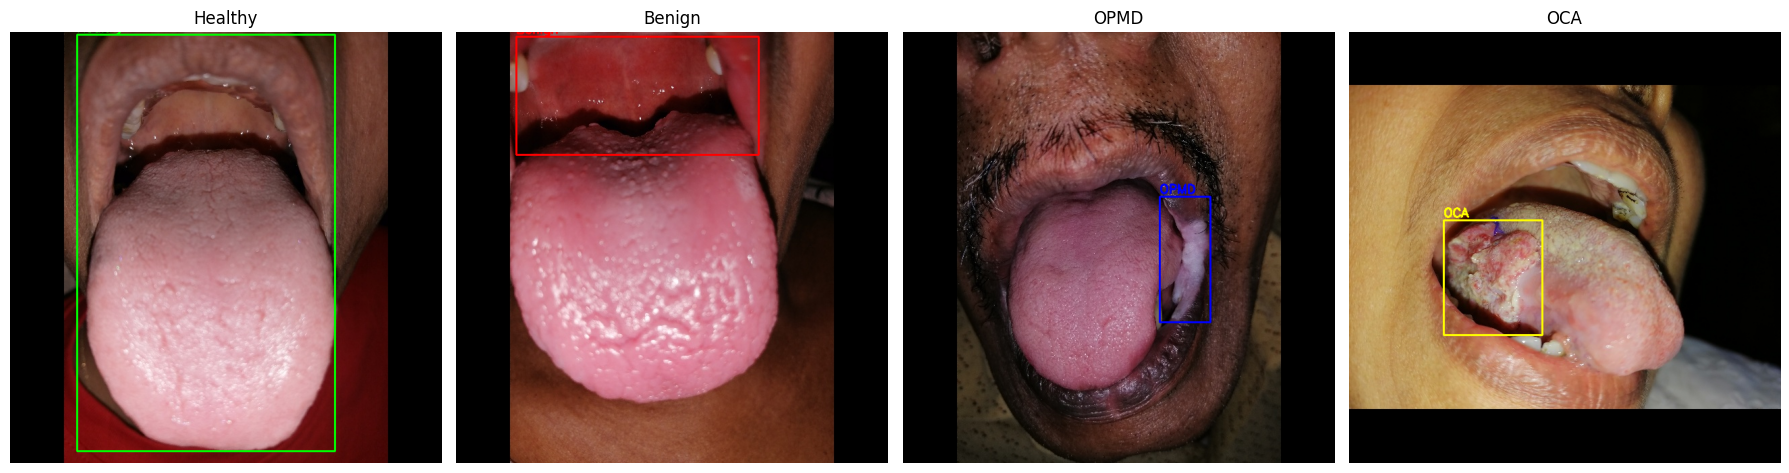

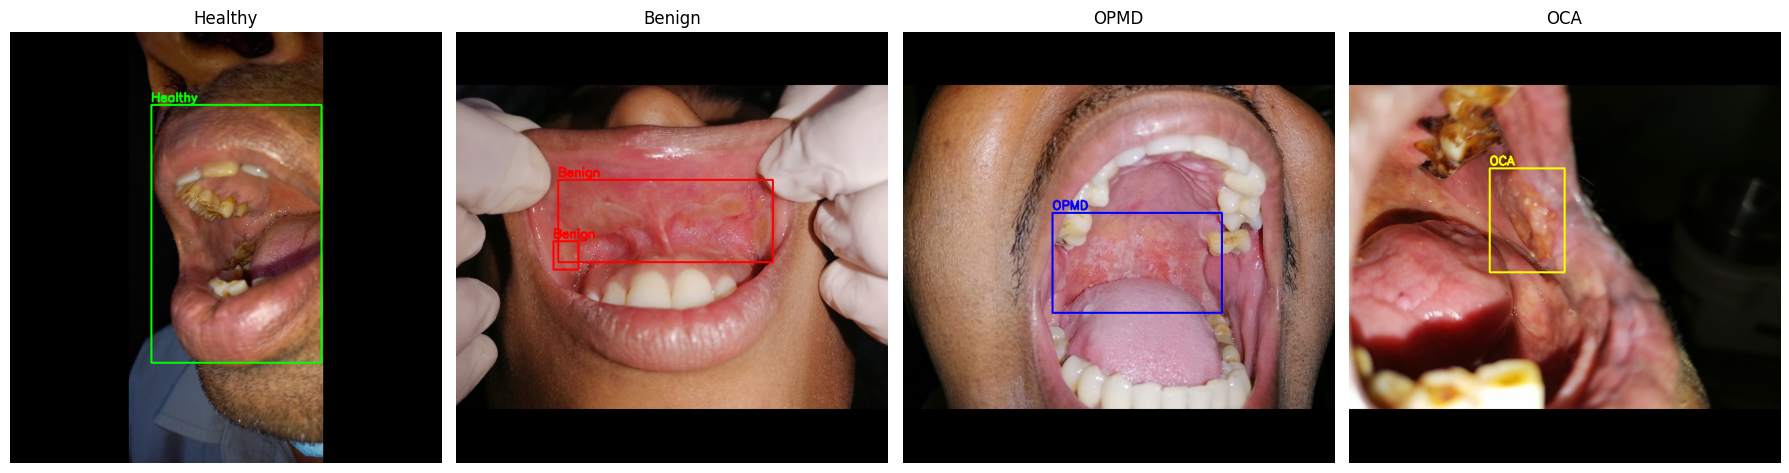

In [8]:
def draw_yolo_bboxes(image_path, label_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    h, w = img.shape[:2]
    if not os.path.exists(label_path):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls_id, x_c, y_c, bw, bh = map(float, line.strip().split())
        cls_id = int(cls_id)
        x = int((x_c - bw / 2) * w)
        y = int((y_c - bh / 2) * h)
        box_w = int(bw * w)
        box_h = int(bh * h)
        color = [(0,255,0), (0,0,255), (255,0,0), (0,255,255)][cls_id]
        cv2.rectangle(img, (x, y), (x+box_w, y+box_h), color, 2)
        cv2.putText(img, CLASS_NAMES[cls_id], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def show_random_samples(split="train"):
    fig, axes = plt.subplots(1, len(CLASS_NAMES), figsize=(18,5))
    for i, cls in enumerate(CLASS_NAMES):
        img_dir = os.path.join(YOLO_DATASET_DIR, split, cls, "images")
        lbl_dir = os.path.join(YOLO_DATASET_DIR, split, cls, "labels")
        if not os.path.exists(img_dir):
            continue
        imgs = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".png"))]
        if not imgs:
            continue
        sample = random.choice(imgs)
        img_rgb = draw_yolo_bboxes(os.path.join(img_dir, sample),
                                   os.path.join(lbl_dir, sample.rsplit(".",1)[0]+".txt"))
        axes[i].imshow(img_rgb)
        axes[i].set_title(cls)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Optional verification
show_random_samples("train")
show_random_samples("val")


/tmp/ipython-input-1048447896.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="Set2")


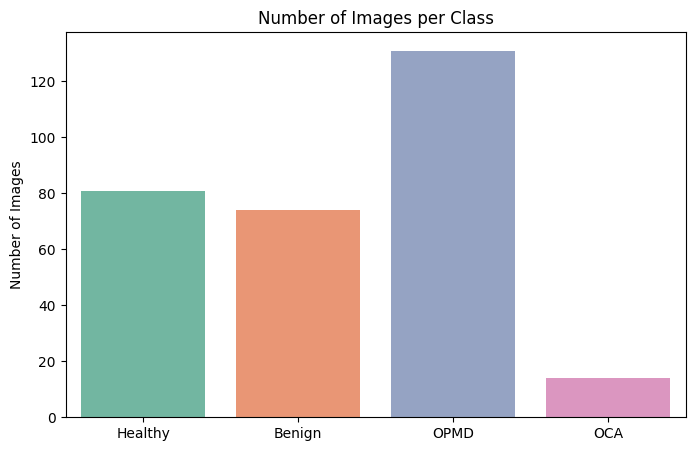

/tmp/ipython-input-1048447896.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(annotation_counts.keys()), y=list(annotation_counts.values()), palette="Set3")


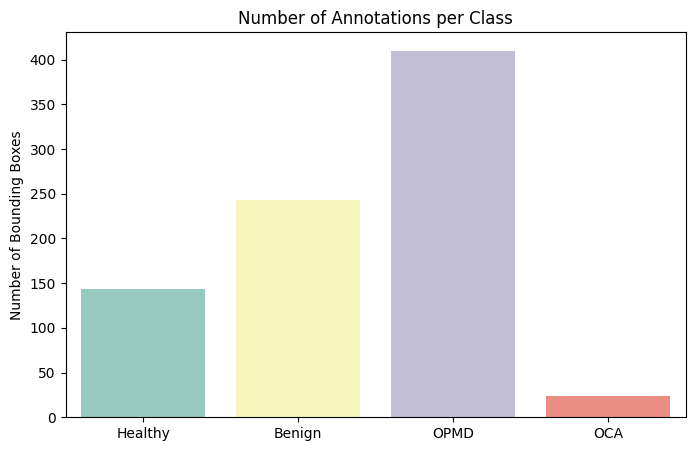

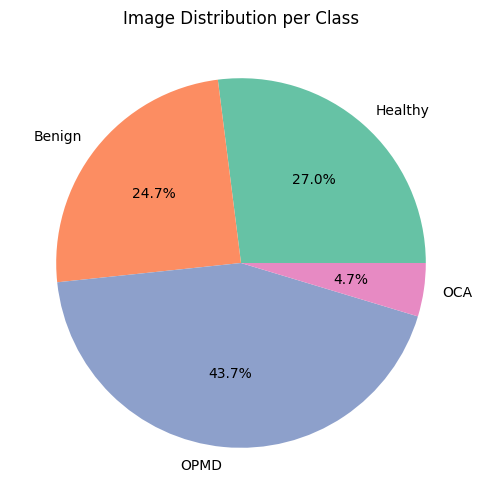

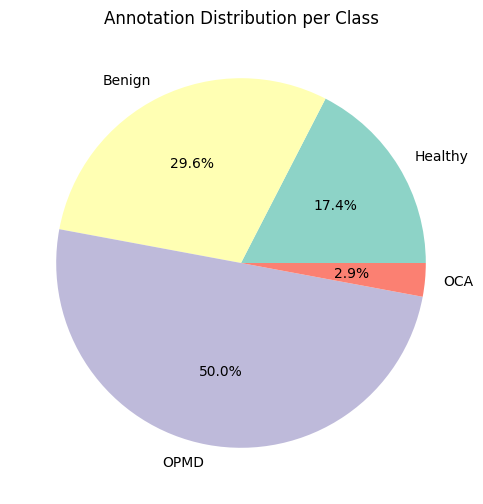

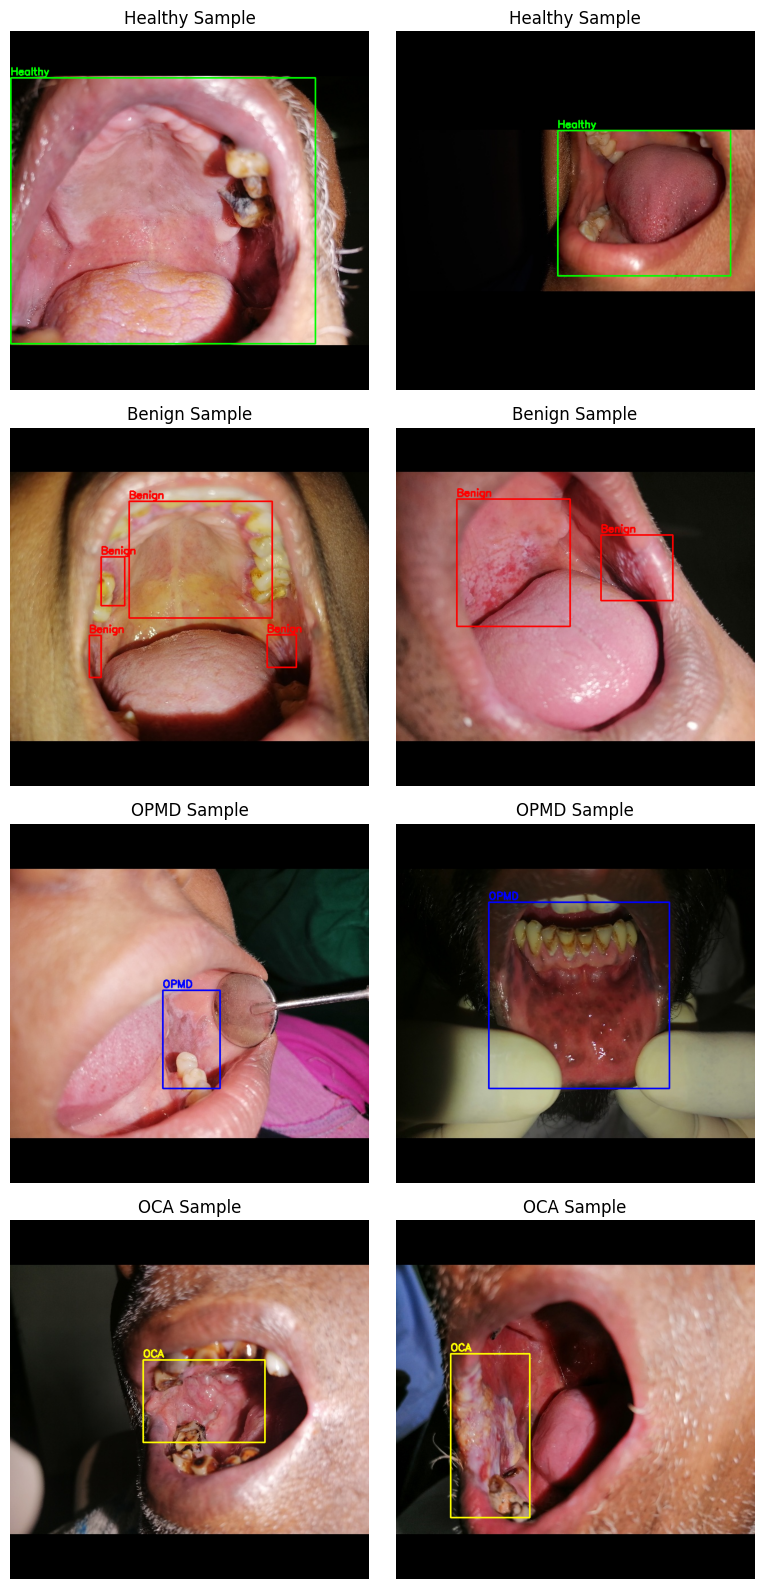

In [9]:
# =============================
# DATASET ANALYTICS & VISUALIZATION
# =============================
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Count number of images per class (from folder structure)
image_counts = {}
annotation_counts = {cls: 0 for cls in CLASS_NAMES}

for cls in CLASS_NAMES:
    class_img_dir = os.path.join(DATA_ROOT, "Training", cls)
    if os.path.exists(class_img_dir):
        imgs = [f for f in os.listdir(class_img_dir) if f.lower().endswith((".jpg",".png"))]
        image_counts[cls] = len(imgs)
    else:
        image_counts[cls] = 0

# Count number of annotations per class
for ann in annotations["annotations"]:
    cat_id = ann["category_id"]
    if cat_id < len(CLASS_NAMES):
        annotation_counts[CLASS_NAMES[cat_id]] += 1

# =============================
# BAR CHART: Images per Class
# =============================
plt.figure(figsize=(8,5))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="Set2")
plt.title("Number of Images per Class")
plt.ylabel("Number of Images")
plt.show()

# =============================
# BAR CHART: Annotations per Class
# =============================
plt.figure(figsize=(8,5))
sns.barplot(x=list(annotation_counts.keys()), y=list(annotation_counts.values()), palette="Set3")
plt.title("Number of Annotations per Class")
plt.ylabel("Number of Bounding Boxes")
plt.show()

# =============================
# PIE CHART: Class Distribution (Images)
# =============================
plt.figure(figsize=(6,6))
plt.pie(list(image_counts.values()), labels=list(image_counts.keys()), autopct='%1.1f%%', colors=sns.color_palette("Set2"))
plt.title("Image Distribution per Class")
plt.show()

# =============================
# PIE CHART: Class Distribution (Annotations)
# =============================
plt.figure(figsize=(6,6))
plt.pie(list(annotation_counts.values()), labels=list(annotation_counts.keys()), autopct='%1.1f%%', colors=sns.color_palette("Set3"))
plt.title("Annotation Distribution per Class")
plt.show()

# =============================
# SHOW SAMPLE IMAGES PER CLASS
# =============================
def show_sample_images_per_class(num_samples=2):
    fig, axes = plt.subplots(len(CLASS_NAMES), num_samples, figsize=(4*num_samples, 4*len(CLASS_NAMES)))
    if len(CLASS_NAMES) == 1:
        axes = [axes]
    for i, cls in enumerate(CLASS_NAMES):
        img_dir = os.path.join(DATA_ROOT, "Training", cls)
        lbl_dir = os.path.join(YOLO_DATASET_DIR, "train", cls, "labels")
        if not os.path.exists(img_dir):
            continue
        imgs = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".png"))]
        if len(imgs) == 0:
            continue
        samples = random.sample(imgs, min(num_samples, len(imgs)))
        for j, img_file in enumerate(samples):
            img_path = os.path.join(img_dir, img_file)
            lbl_path = os.path.join(lbl_dir, img_file.rsplit(".",1)[0]+".txt")
            img_rgb = draw_yolo_bboxes(img_path, lbl_path)
            axes[i][j].imshow(img_rgb)
            axes[i][j].axis("off")
            axes[i][j].set_title(f"{cls} Sample")
    plt.tight_layout()
    plt.show()

# Visualize 2 samples per class
show_sample_images_per_class(num_samples=2)

In [ ]:
# =============================
# YOLOv8 TRAINING WITH CLASS IMBALANCE HANDLING
# =============================

# Load pretrained YOLOv8s model
model = YOLO("yolov8s.pt")  # transfer learning

# Define class weights (increase weight for rare class OCA)
# Example: Healthy=1, Benign=1, OPMD=1, OCA=5
class_weights = [1.0, 1.0, 1.0, 5.0]

# Train the model
model.train(
    data=os.path.join(YOLO_DATASET_DIR, "dataset.yaml"),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project=DATA_ROOT,
    name="oral_cancer_yolo",
    pretrained=True,
    device=0,                # GPU 0
    workers=4,               # adjust according to your system
    augment=True,            # apply YOLO augmentations including mosaic
    save_best=True,          # save best model automatically
    class_weights=class_weights
)


In [14]:
# -----------------------------
# CONFIG
# -----------------------------
IMG_SIZE = 640
BATCH_SIZE = 16
EPOCHS = 80
CONF_THRESH = 0.25
DATA_ROOT = "/content/drive/MyDrive/ORAL_resized1"
YOLO_DATASET_DIR = os.path.join(DATA_ROOT, "yolo_dataset")
ANNOTATION_FILE = os.path.join(DATA_ROOT, "annotations_resized1.json")
CLASS_NAMES = ["Healthy", "Benign", "OPMD", "OCA"]

# -----------------------------
# OPTIONAL: Oversample OCA
# -----------------------------
# Duplicate OCA training images to balance dataset
train_oca_dir = os.path.join(YOLO_DATASET_DIR, "train", "OCA", "images")
train_oca_lbl_dir = os.path.join(YOLO_DATASET_DIR, "train", "OCA", "labels")
if os.path.exists(train_oca_dir):
    oca_images = [f for f in os.listdir(train_oca_dir) if f.lower().endswith((".jpg",".png"))]
    # oversample factor: number of times to duplicate images
    oversample_factor = max(1, int( max(len(os.listdir(os.path.join(YOLO_DATASET_DIR,"train",cls,"images")))
                                        for cls in CLASS_NAMES if cls!="OCA") / len(oca_images) ))
    for i in range(oversample_factor-1):
        for fname in oca_images:
            # duplicate image
            src_img = os.path.join(train_oca_dir, fname)
            dst_img = os.path.join(train_oca_dir, f"dup{i}_{fname}")
            shutil.copy2(src_img, dst_img)
            # duplicate label
            src_lbl = os.path.join(train_oca_lbl_dir, fname.rsplit(".",1)[0]+".txt")
            dst_lbl = os.path.join(train_oca_lbl_dir, f"dup{i}_{fname.rsplit('.',1)[0]}.txt")
            shutil.copy2(src_lbl, dst_lbl)
print(f"OCA oversampling done: factor {oversample_factor}")


OCA oversampling done: factor 9


In [15]:
# -----------------------------
# TRAIN YOLOv8
# -----------------------------
model = YOLO("yolov8s.pt")  # pretrained YOLOv8s

model.train(
    data=os.path.join(YOLO_DATASET_DIR, "dataset.yaml"),
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    project=DATA_ROOT,
    name="oral_cancer_yolo",
    pretrained=True,
    augment=True,       # apply augmentations including mosaic
)

Ultralytics 8.3.200 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/ORAL_resized1/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=oral_cancer_yolo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ef1c0123da0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0


Overall Accuracy: 0.4967

Classification Report (numbers):

Healthy: Precision=0.464, Recall=0.629, F1=0.534, Support=62.0
Benign: Precision=0.600, Recall=0.077, F1=0.136, Support=78.0
OPMD: Precision=0.636, Recall=0.687, F1=0.660, Support=150.0
OCA: Precision=0.250, Recall=0.100, F1=0.143, Support=10.0

Confusion Matrix:
 [[ 39   1  15   0]
 [ 20   6  36   0]
 [ 25   3 103   3]
 [  0   0   8   1]]


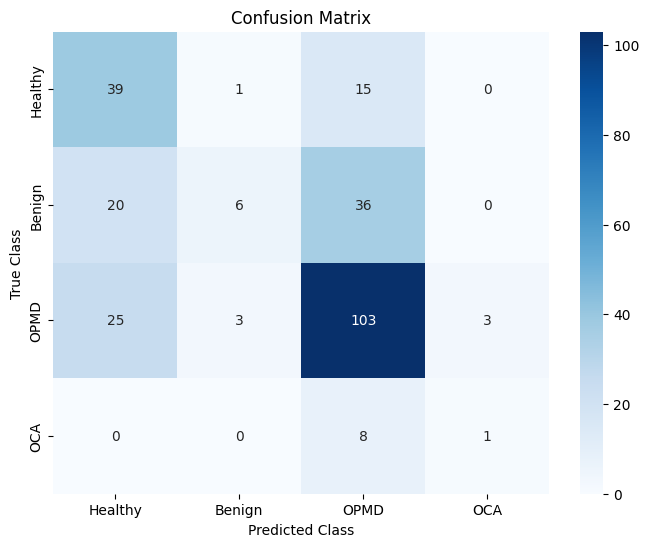

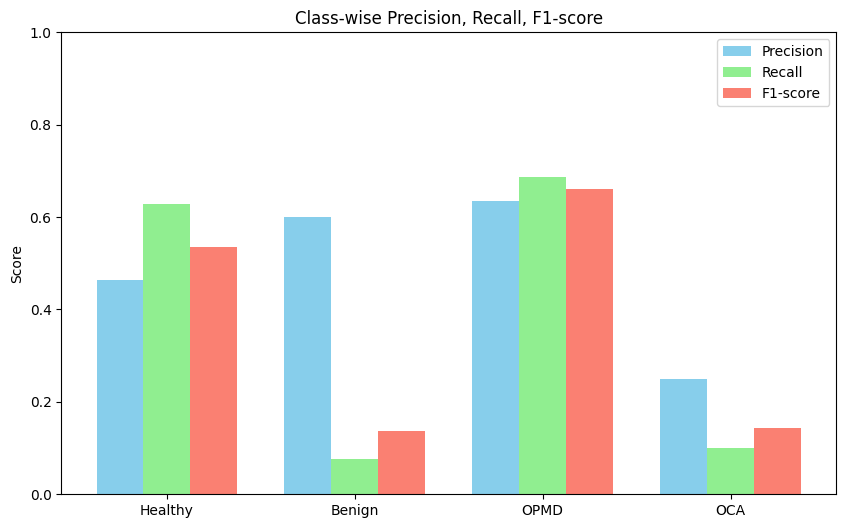

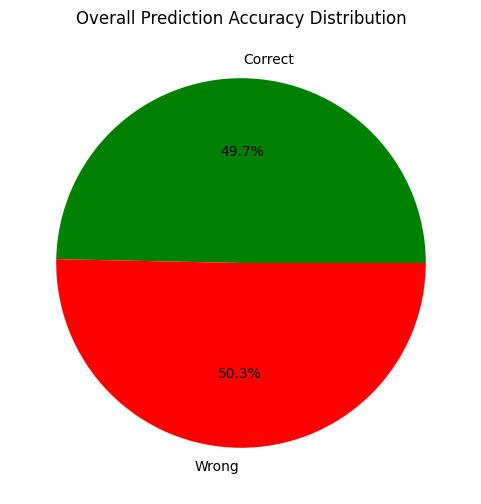

In [17]:
# Load the trained YOLO model
model_path = os.path.join(DATA_ROOT, "oral_cancer_yolo", "weights", "best.pt")
model = YOLO(model_path)

# Load annotations
with open(ANNOTATION_FILE, "r") as f:
    annotations = json.load(f)

# Map image file -> true class
image_file_to_label = {}
categories = {cat['id']: cat['name'] for cat in annotations['categories']}
for img in annotations['images']:
    anns = [ann for ann in annotations['annotations'] if ann['image_id']==img['id']]
    if anns:
        cat_id = anns[0]['category_id']
        if cat_id < len(CLASS_NAMES):
            image_file_to_label[img['file_name']] = CLASS_NAMES[cat_id]

# Prepare lists for evaluation
y_true = []
y_pred = []

# Evaluate all validation images
for cls in CLASS_NAMES:
    img_dir = os.path.join(YOLO_DATASET_DIR, "val", cls, "images")
    if not os.path.exists(img_dir):
        continue
    for fname in os.listdir(img_dir):
        full_path = os.path.join(img_dir, fname)
        true_label = image_file_to_label.get(fname, "Unknown")

        results = model.predict(full_path, imgsz=IMG_SIZE, conf=CONF_THRESH, verbose=False)
        pred = results[0]

        if len(pred.boxes) > 0:
            # Take highest-confidence prediction
            confs = pred.boxes.conf.cpu().numpy()
            best_idx = np.argmax(confs)
            pred_class_id = int(pred.boxes.cls[best_idx].cpu().numpy())
            pred_label = CLASS_NAMES[pred_class_id] if pred_class_id < len(CLASS_NAMES) else "Unknown"
        else:
            pred_label = "None"

        y_true.append(true_label)
        y_pred.append(pred_label)

# -----------------------------
# NUMERIC METRICS
# -----------------------------
# Overall accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {acc:.4f}\n")

# Classification report: precision, recall, F1-score per class
report = classification_report(y_true, y_pred, labels=CLASS_NAMES, zero_division=0, output_dict=True)
print("Classification Report (numbers):\n")
for cls in CLASS_NAMES:
    print(f"{cls}: Precision={report[cls]['precision']:.3f}, Recall={report[cls]['recall']:.3f}, F1={report[cls]['f1-score']:.3f}, Support={report[cls]['support']}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=CLASS_NAMES)
print("\nConfusion Matrix:\n", cm)

# -----------------------------
# VISUALIZATIONS
# -----------------------------
# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# 2. Bar Charts: Precision, Recall, F1 per class
precision = [report[cls]['precision'] for cls in CLASS_NAMES]
recall = [report[cls]['recall'] for cls in CLASS_NAMES]
f1 = [report[cls]['f1-score'] for cls in CLASS_NAMES]

x = np.arange(len(CLASS_NAMES))
width = 0.25

plt.figure(figsize=(10,6))
plt.bar(x - width, precision, width, label='Precision', color='skyblue')
plt.bar(x, recall, width, label='Recall', color='lightgreen')
plt.bar(x + width, f1, width, label='F1-score', color='salmon')
plt.xticks(x, CLASS_NAMES)
plt.ylabel("Score")
plt.ylim(0,1)
plt.title("Class-wise Precision, Recall, F1-score")
plt.legend()
plt.show()

# 3. Pie chart: distribution of correct vs wrong predictions
correct = sum([y_true[i]==y_pred[i] for i in range(len(y_true))])
wrong = len(y_true) - correct

plt.figure(figsize=(6,6))
plt.pie([correct, wrong], labels=["Correct", "Wrong"], autopct='%1.1f%%', colors=["green","red"])
plt.title("Overall Prediction Accuracy Distribution")
plt.show()